# Multiclass Support Vector Machine

**This material is heavily based on the popular Standford CS231n lecture material.** [Please check on their website for more detailed information](https://cs231n.github.io/).

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times",
    "font.size": 10,
})

from utils import *

## Class SVM

In [18]:
from utils import * 

class SVM():
    def __init__(self):
        self.W = None

    
    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100, batch_size=200, verbose=True):
        '''
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        '''
          
        num_train, dim = X.shape
        num_classes = len(np.unique(y)) 
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            # Sample batch_size elements from the training data and their           
            # corresponding labels to use in this round of gradient descent.        
            # Store the data in X_batch and their corresponding labels in           
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   
            # and y_batch should have shape (batch_size,)                           
            
            batch_indices = np.random.choice(num_train, batch_size, replace=False)
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]
            
            # evaluate loss and gradient
            loss, grad = svm_loss(self.W, X_batch, y_batch, reg)
            loss_history.append(loss)

            # Update the weights using the gradient and the learning rate.          
            self.W = self.W - learning_rate * grad
     
            if verbose and it % 1000 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            if loss < 1.0:
                print('after iteration %d, minimum loss %f' % (it, loss))
                break

        return loss_history
    

    def predict(self, X, k=1, L=2):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        
        y_pred = np.zeros(X.shape[0])
        scores = X.dot(self.W)
        y_pred = scores.argmax(axis=1)

        return y_pred


## Breast Cancer Wisconsin

We are going to use the Diagnostic Wisconsin breast cancer dataset is available in public domain.

We obtained the dataset from the following link:  

https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic


This dataset is also available in scikit-learn:  

https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.load_breast_cancer.html

The original labels are characters: `M` and `B`. For the SVM to work, the labels must be numbers. Hence, we change the labels:
* `M` is replaced with `1`
* `B` is replaced with `0`

In [19]:
data = np.loadtxt("./datasets/breast_cancer/wdbc.data", delimiter=",", dtype=str)
X = np.float32(data[:, 2:])  # 10 dimensions

# Diagnosis (M = malignant, B = benign)
y = np.zeros(X.shape[0], dtype=np.int32) 
y[np.where(data[:,1]=='M')] = 1
y[np.where(data[:,1]=='B')] = 0

print("Dimension numbers :", X.shape[1])
print("Number of data    :", X.shape[0])
print("Labels            :", np.unique(y))

Dimension numbers : 30
Number of data    : 569
Labels            : [0 1]


In [20]:
X_train = X[0:400, :]
y_train = y[0:400]
X_test  = X[401:, :]
y_test  = y[401:]

num_test = X_test.shape[0]

## Run the Classifier

In [21]:
classifier = SVM()
loss_hist = classifier.train(X_train, y_train, num_iters=100000)

iteration 0 / 100000: loss 1.076542
iteration 1000 / 100000: loss 6.848104
iteration 2000 / 100000: loss 76.057854
iteration 3000 / 100000: loss 4.620175
iteration 4000 / 100000: loss 88.488126
iteration 5000 / 100000: loss 8.868114
iteration 6000 / 100000: loss 11.011946
iteration 7000 / 100000: loss 7.827468
iteration 8000 / 100000: loss 9.608775
iteration 9000 / 100000: loss 7.385514
iteration 10000 / 100000: loss 4.431310
iteration 11000 / 100000: loss 4.557953
iteration 12000 / 100000: loss 4.962564
iteration 13000 / 100000: loss 6.489902
iteration 14000 / 100000: loss 4.671580
iteration 15000 / 100000: loss 9.252978
iteration 16000 / 100000: loss 5.688042
iteration 17000 / 100000: loss 8.878512
iteration 18000 / 100000: loss 21.740447
iteration 19000 / 100000: loss 10.276673
iteration 20000 / 100000: loss 6.022319
iteration 21000 / 100000: loss 4.051136
iteration 22000 / 100000: loss 7.364814
iteration 23000 / 100000: loss 3.336870
iteration 24000 / 100000: loss 16.456571
iterati

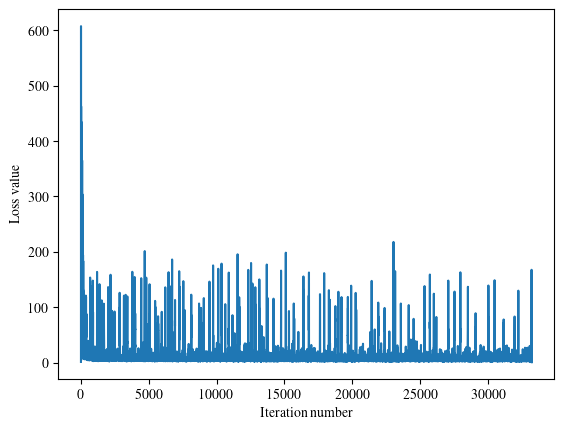

In [22]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

## Run with the Test Dataset

In [23]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_test_pred = classifier.predict(X_test)
print('validation accuracy: %f' % (np.mean(y_test == y_test_pred), ))

training accuracy: 0.930000
validation accuracy: 0.922619
